# HDFS Log Anomaly Detection - Part 2: Feature Engineering

**Author**: AI-Based Log Anomaly Detection Team  
**Input**: Preprocessed HDFS logs from Part 1  
**Output**: Engineered features matrix ready for ML models

---

## 1. Setup & Dependencies

In [ ]:
# Install dependencies
!pip install -q pandas numpy matplotlib seaborn scikit-learn

import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import pickle
from tqdm import tqdm

warnings.filterwarnings('ignore')

# Configure visualization
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print('✓ Dependencies loaded successfully')

✓ Dependencies loaded successfully


## 2. Mount Google Drive & Load Data



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Setup paths
base_path = '/content/drive/MyDrive/HDFS_Project'
data_path = os.path.join(base_path, 'data')
results_path = os.path.join(base_path, 'results')

# Load preprocessed data
preprocessed_file = os.path.join(data_path, 'hdfs_v1_preprocessed.csv')
df = pd.read_csv(preprocessed_file)

print(f'✓ Preprocessed data loaded')
print(f'✓ Dataset shape: {df.shape}')
print(f'✓ Columns: {df.columns.tolist()}')
print(f'\nFirst 3 rows:')
print(df.head(3))

Mounted at /content/drive
✓ Preprocessed data loaded
✓ Dataset shape: (4791517, 7)
✓ Columns: ['timestamp', 'log_level', 'component', 'message', 'BlockId', 'hour', 'Label']

First 3 rows:
             timestamp log_level                 component  \
0  2008-11-09 20:35:18      INFO  dfs.DataNode$DataXceiver   
1  2008-11-09 20:35:18      INFO          dfs.FSNamesystem   
2  2008-11-09 20:35:19      INFO  dfs.DataNode$DataXceiver   

                                             message  \
0  receiving block blk_-1608999687919862906 src: ...   
1  block* namesystem.allocateblock: /mnt/hadoop/m...   
2  receiving block blk_-1608999687919862906 src: ...   

                    BlockId                 hour   Label  
0  blk_-1608999687919862906  2008-11-09 20:00:00  Normal  
1  blk_-1608999687919862906  2008-11-09 20:00:00  Normal  
2  blk_-1608999687919862906  2008-11-09 20:00:00  Normal  


## 3. Statistical Features

Extract basic statistical properties from log messages

In [ ]:
print('Creating statistical features...')

# Message length features
df['msg_length'] = df['message'].fillna('').str.len()
df['msg_word_count'] = df['message'].fillna('').str.split().str.len()
df['msg_unique_chars'] = df['message'].fillna('').apply(lambda x: len(set(x)))

# Character type counts
df['msg_digit_count'] = df['message'].fillna('').str.count(r'\d')
df['msg_uppercase_count'] = df['message'].fillna('').str.count(r'[A-Z]')
df['msg_lowercase_count'] = df['message'].fillna('').str.count(r'[a-z]')
df['msg_special_char_count'] = df['message'].fillna('').str.count(r'[^a-zA-Z0-9\s]')

# Advanced statistics
def calc_avg_word_length(message):
    words = str(message).split()
    if len(words) > 0:
        return np.mean([len(w) for w in words])
    return 0

df['avg_word_length'] = df['message'].fillna('').apply(calc_avg_word_length)

# IP address count
df['ip_address_count'] = df['message'].fillna('').str.count(r'\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b')

# Hex value count
df['hex_value_count'] = df['message'].fillna('').str.count(r'0x[0-9a-fA-F]+')

stat_features = ['msg_length', 'msg_word_count', 'msg_unique_chars', 'msg_digit_count',
                 'msg_uppercase_count', 'msg_lowercase_count', 'msg_special_char_count',
                 'avg_word_length', 'ip_address_count', 'hex_value_count']

print(f'✓ Created {len(stat_features)} statistical features')
print(f'\nStatistical Features Summary:')
print(df[stat_features].describe().round(2))

Creating statistical features...
✓ Created 10 statistical features

Statistical Features Summary:
       msg_length  msg_word_count  msg_unique_chars  msg_digit_count  \
count  4791517.00      4791517.00        4791517.00       4791517.00   
mean        91.92            7.27             30.12            37.97   
std         21.26            2.06              2.37             9.48   
min         36.00            3.00             18.00            15.00   
25%         75.00            6.00             28.00            34.00   
50%         92.00            7.00             30.00            40.00   
75%        105.00            9.00             32.00            44.00   
max        266.00           24.00             43.00            69.00   

       msg_uppercase_count  msg_lowercase_count  msg_special_char_count  \
count            4791517.0           4791517.00              4791517.00   
mean                   0.0                38.77                    8.90   
std                    0.0  

In [ ]:
# --- Nettoyage de la Tâche 3 ---
# On supprime les colonnes qui n'ont aucune variation (que des 0 d'après tes stats)
cols_to_drop = ['msg_uppercase_count', 'hex_value_count']

# On vérifie si elles existent avant de supprimer pour éviter une erreur
df.drop(columns=[c for c in cols_to_drop if c in df.columns], inplace=True)

print(f"Nettoyage Tâche 3 terminé : {cols_to_drop} supprimés.")

Nettoyage Tâche 3 terminé : ['msg_uppercase_count', 'hex_value_count'] supprimés.


## 4. Pattern-Based Features

Extract log templates and template-based features

In [ ]:
print('Creating pattern-based features...')

def extract_log_template(message):
    """Extract log template by replacing variable values with placeholders"""
    if pd.isna(message):
        return 'UNKNOWN'

    template = str(message)
    # Replace IP addresses
    template = re.sub(r'\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b', '<IP>', template)
    # Replace numbers
    template = re.sub(r'\b\d+\b', '<NUM>', template)
    # Replace hex values
    template = re.sub(r'0x[0-9a-fA-F]+', '<HEX>', template)
    # Replace file paths
    template = re.sub(r'[/\\]\S+', '<PATH>', template)
    # Truncate to 150 chars for efficiency
    return template[:150]

print('Extracting log templates...')
df['log_template'] = df['message'].fillna('').apply(extract_log_template)

# Template frequency
template_freq = df['log_template'].value_counts()
df['template_frequency'] = df['log_template'].map(template_freq)
df['template_rarity'] = 1.0 / (df['template_frequency'] + 1)  # Add 1 to avoid division by zero

print(f'✓ Total unique templates: {df["log_template"].nunique():,}')
print(f'\nTop 10 Most Frequent Templates:')
print(template_freq.head(10))

print(f'\nTemplate frequency statistics:')
print(df['template_frequency'].describe())

Creating pattern-based features...
Extracting log templates...
✓ Total unique templates: 952,089

Top 10 Most Frequent Templates:
log_template
receiving block blk_-<NUM> src: <PATH> dest: <PATH>                                                 362622
block* namesystem.addstoredblock: blockmap updated: <IP>:<NUM> is added to blk_-<NUM> size <NUM>    360427
packetresponder <NUM> for block blk_-<NUM> terminating                                              358414
deleting block blk_-<NUM> file <PATH>                                                               263894
block* namesystem.delete: blk_-<NUM> is added to invalidset of <IP>:<NUM>                           263257
received block blk_-<NUM> of size <NUM> from <PATH>                                                 254591
<IP>:<NUM> served block blk_-<NUM> to <PATH>                                                        187785
<IP>:<NUM>:got exception while serving blk_-<NUM> to <PATH>                                         164224
b

## 5. Keyword-Based Features

Count anomaly-related keywords in log messages

In [ ]:
print('Creating keyword-based features...')

# Define keyword dictionaries
keyword_sets = {
    'error_keywords': ['error', 'failed', 'exception', 'fatal', 'critical', 'fault', 'failure'],
    'warning_keywords': ['warn', 'warning', 'deprecated', 'caution', 'suspicious'],
    'connection_keywords': ['connection', 'timeout', 'refused', 'unreachable', 'disconnect', 'closed'],
    'memory_keywords': ['memory', 'heap', 'oom', 'out of', 'overflow', 'buffer'],
    'io_keywords': ['io', 'disk', 'read', 'write', 'file', 'filesystem', 'storage'],
    'security_keywords': ['permission', 'denied', 'unauthorized', 'forbidden', 'security', 'access'],
    'data_keywords': ['data', 'corrupt', 'invalid', 'mismatch', 'inconsistent', 'incomplete']
}

def count_keywords(message, keywords):
    """Count keyword occurrences in message"""
    if pd.isna(message):
        return 0
    message_lower = str(message).lower()
    return sum(1 for kw in keywords if kw in message_lower)

# Create keyword features
for feature_name, keywords in keyword_sets.items():
    df[feature_name] = df['message'].apply(lambda x: count_keywords(x, keywords))

# Total anomaly keywords
keyword_cols = list(keyword_sets.keys())
df['total_anomaly_keywords'] = df[keyword_cols].sum(axis=1)

print(f'✓ Created {len(keyword_cols) + 1} keyword features')
print(f'\nKeyword Feature Summary:')
print(df[keyword_cols + ['total_anomaly_keywords']].describe())

Creating keyword-based features...
✓ Created 8 keyword features

Keyword Feature Summary:
       error_keywords  warning_keywords  connection_keywords  memory_keywords  \
count    4.791517e+06         4791517.0         4.791517e+06        4791517.0   
mean     6.961136e-02               0.0         1.794839e-05              0.0   
std      2.544975e-01               0.0         4.285496e-03              0.0   
min      0.000000e+00               0.0         0.000000e+00              0.0   
25%      0.000000e+00               0.0         0.000000e+00              0.0   
50%      0.000000e+00               0.0         0.000000e+00              0.0   
75%      0.000000e+00               0.0         0.000000e+00              0.0   
max      2.000000e+00               0.0         2.000000e+00              0.0   

        io_keywords  security_keywords  data_keywords  total_anomaly_keywords  
count  4.791517e+06          4791517.0   4.791517e+06            4.791517e+06  
mean   2.020485e-01 

In [ ]:
# --- SECTION NETTOYAGE (Basée sur tes résultats précédents) ---
# On supprime les colonnes qui n'ont que des zéros pour ne pas encombrer l'IA
cols_with_zero_variance = ['warning_keywords', 'memory_keywords', 'security_keywords']
df.drop(columns=[c for c in cols_with_zero_variance if c in df.columns], inplace=True)

print(f'✓ Created keyword features')
print(f'✓ Cleaned: {cols_with_zero_variance} removed (zero variance)')

# Affichage des statistiques finales
remaining_cols = [c for c in keyword_cols if c not in cols_with_zero_variance] + ['total_anomaly_keywords']
print(f'\nKeyword Feature Summary (Remaining columns):')
print(df[remaining_cols].describe())

✓ Created keyword features
✓ Cleaned: ['warning_keywords', 'memory_keywords', 'security_keywords'] removed (zero variance)

Keyword Feature Summary (Remaining columns):
       error_keywords  connection_keywords   io_keywords  data_keywords  \
count    4.791517e+06         4.791517e+06  4.791517e+06   4.791517e+06   
mean     6.961136e-02         1.794839e-05  2.020485e-01   2.205268e-01   
std      2.544975e-01         4.285496e-03  4.044012e-01   4.146019e-01   
min      0.000000e+00         0.000000e+00  0.000000e+00   0.000000e+00   
25%      0.000000e+00         0.000000e+00  0.000000e+00   0.000000e+00   
50%      0.000000e+00         0.000000e+00  0.000000e+00   0.000000e+00   
75%      0.000000e+00         0.000000e+00  0.000000e+00   0.000000e+00   
max      2.000000e+00         2.000000e+00  3.000000e+00   1.000000e+00   

       total_anomaly_keywords  
count            4.791517e+06  
mean             4.922047e-01  
std              7.827812e-01  
min              0.000000e+

## 6. Categorical Features & Encoding
On encode les variables catégoriques, comme les niveaux de logs (log_level) en valeurs numériques et en one-hot encoding, pour rendre ces informations exploitables par les modèles ML.

In [ ]:
print('Creating categorical features...')

# Encode log levels
log_level_mapping = {'DEBUG': 1, 'INFO': 2, 'WARN': 3, 'ERROR': 4, 'FATAL': 5}
df['log_level_encoded'] = df['log_level'].map(log_level_mapping).fillna(0).astype(int)

# One-hot encode log levels
log_level_dummies = pd.get_dummies(df['log_level'], prefix='log_level', drop_first=False)

# Extract thread number if available
def extract_thread_number(thread_str):
    match = re.search(r'\d+', str(thread_str))
    return int(match.group(0)) if match else 0
print(f'✓ Log level encoding: {log_level_mapping}')
print(f'✓ One-hot encoded log levels: {log_level_dummies.columns.tolist()}')
print(f'✓ Categorical features created')

# Merge one-hot encoded columns
df = pd.concat([df, log_level_dummies], axis=1)

Creating categorical features...
✓ Log level encoding: {'DEBUG': 1, 'INFO': 2, 'WARN': 3, 'ERROR': 4, 'FATAL': 5}
✓ One-hot encoded log levels: ['log_level_INFO', 'log_level_WARN']
✓ Categorical features created


## 7. Session (Block) Features
On agrège les logs par BlockId pour créer des features au niveau session : nombre de logs, moyenne/max des niveaux de log, somme/moyenne des mots-clés d’anomalie, longueur moyenne/max des messages, etc. Cela réduit le dataset de millions de logs à des sessions représentatives.

In [ ]:
print('Creating session features...')

# On définit dynamiquement les colonnes log_level présentes (INFO, WARN, etc.)
log_level_cols = [c for c in df.columns if c.startswith('log_level_') and c != 'log_level_encoded']

# 1. Préparation des règles d'agrégation
agg_rules = {
    'message': 'count',
    'log_level_encoded': ['mean', 'max'],
    'total_anomaly_keywords': ['sum', 'mean'],
    'msg_length': ['mean', 'max'],
}

# On ajoute les colonnes One-Hot aux règles (on veut la somme des INFO/WARN par bloc)
for col in log_level_cols:
    agg_rules[col] = 'sum'

# 2. Exécution de l'agrégation
session_stats = df.groupby('BlockId').agg(agg_rules).reset_index()

# 3. Renommage propre des colonnes (pour gérer le multi-index)
# On crée une liste de noms simples
new_columns = ['BlockId', 'session_log_count', 'session_avg_level', 'session_max_level',
               'session_anomaly_kw_sum', 'session_anomaly_kw_mean',
               'session_avg_msg_length', 'session_max_msg_length']

# On ajoute les noms pour les colonnes log_level (ex: log_level_INFO_sum)
for col in log_level_cols:
    new_columns.append(f'{col}_sum')

session_stats.columns = new_columns

# 4. Suppression du gros DataFrame original pour ne garder que les sessions (Essentiel pour la suite)
# Au lieu de merger sur 5 millions de lignes, on remplace df par session_stats
df = session_stats

print(f'✓ Session features created')
print(f'✓ New dataset size: {df.shape[0]} blocks (instead of 5 million logs)')
print(f'\nSession Statistics:')
print(df.describe())

Creating session features...
✓ Session features created
✓ New dataset size: 243173 blocks (instead of 5 million logs)

Session Statistics:
       session_log_count  session_avg_level  session_max_level  \
count      243173.000000      243173.000000      243173.000000   
mean           19.704149           2.054986           2.536145   
std             6.141837           0.068741           0.498693   
min             1.000000           2.000000           2.000000   
25%            16.000000           2.000000           2.000000   
50%            18.000000           2.062500           3.000000   
75%            23.000000           2.090909           3.000000   
max           274.000000           2.595745           3.000000   

       session_anomaly_kw_sum  session_anomaly_kw_mean  \
count           243173.000000            243173.000000   
mean                 9.698474                 0.440752   
std                  6.894591                 0.247995   
min                  0.000000     

## 8. Feature Normalization (Scaling)
On normalise toutes les features numériques avec StandardScaler pour centrer les données à moyenne 0 et écart-type 1. Cela permet aux modèles ML d’apprendre plus efficacement et d’éviter que certaines features dominent les autres.

In [ ]:
import pickle
from sklearn.preprocessing import StandardScaler

print('Normalizing features...')

# 1. On sélectionne automatiquement toutes les colonnes numériques SAUF BlockId et Label
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
if 'Label' in numerical_features:
    numerical_features.remove('Label')

print(f'Total numerical features to scale: {len(numerical_features)}')
print(f'Features detected: {numerical_features}')

# 2. Gestion des valeurs manquantes (Sécurité)
df[numerical_features] = df[numerical_features].fillna(0)

# 3. Normalisation
scaler = StandardScaler()
df_scaled_data = scaler.fit_transform(df[numerical_features])

# 4. Création du DataFrame final avec les noms de colonnes originaux
df_final = pd.DataFrame(df_scaled_data, columns=numerical_features)

# On rajoute les colonnes non-numériques pour référence
if 'BlockId' in df.columns:
    df_final['BlockId'] = df['BlockId'].values
if 'Label' in df.columns:
    df_final['Label'] = df['Label'].values

print(f'✓ Features normalized using StandardScaler')
print(f'\nScaled Features Statistics (first 5):')
print(df_final[numerical_features[:5]].describe().round(3))

# 5. Sauvegarde du scaler
scaler_file = os.path.join(data_path, 'feature_scaler.pkl')
with open(scaler_file, 'wb') as f:
    pickle.dump(scaler, f)
print(f'\n✓ Scaler saved to: {scaler_file}')

Normalizing features...
Total numerical features to scale: 9
Features detected: ['session_log_count', 'session_avg_level', 'session_max_level', 'session_anomaly_kw_sum', 'session_anomaly_kw_mean', 'session_avg_msg_length', 'session_max_msg_length', 'log_level_INFO_sum', 'log_level_WARN_sum']
✓ Features normalized using StandardScaler

Scaled Features Statistics (first 5):
       session_log_count  session_avg_level  session_max_level  \
count         243173.000         243173.000         243173.000   
mean               0.000             -0.000              0.000   
std                1.000              1.000              1.000   
min               -3.045             -0.800             -1.075   
25%               -0.603             -0.800             -1.075   
50%               -0.277              0.109              0.930   
75%                0.537              0.523              0.930   
max               41.404              7.867              0.930   

       session_anomaly_kw_sum 

## 9. Create Final Feature Matrix
On construit la matrice finale pour l’IA : on conserve uniquement les features normalisées pour l’entraînement (X) et on garde les colonnes de référence (BlockId, Label) pour l’analyse et l’interprétation des résultats.

In [ ]:
print('Creating final feature matrix...')

# 1. On ne garde que les versions SCALÉES pour l'IA
# df_final contient déjà les colonnes normalisées de la tâche 8
X = df_final[numerical_features]

# 2. On prépare le DataFrame de référence (pour l'analyse des résultats)
# On garde les IDs et les Labels originaux
df_features = df_final.copy()

print(f'✓ Final feature matrix created')
print(f'  Shape: {df_features.shape}')
print(f'  Total numerical features for AI: {len(numerical_features)}')

# 3. Vérification des types
print(f'\nFeature types:')
print(df_features.dtypes.value_counts())

# Aperçu
print(f'\nFirst 3 rows of feature matrix (Scaled):')
print(df_features.head(3))

Creating final feature matrix...
✓ Final feature matrix created
  Shape: (243173, 10)
  Total numerical features for AI: 9

Feature types:
float64    9
object     1
Name: count, dtype: int64

First 3 rows of feature matrix (Scaled):
   session_log_count  session_avg_level  session_max_level  \
0           1.187896           0.816471           0.930143   
1           1.350715           0.758743           0.930143   
2           1.513533           1.206630           0.930143   

   session_anomaly_kw_sum  session_anomaly_kw_mean  session_avg_msg_length  \
0                0.768941                 0.462928               -0.697643   
1                0.913983                 0.526933               -0.719084   
2                1.059024                 0.586525               -0.535793   

   session_max_msg_length  log_level_INFO_sum  log_level_WARN_sum  \
0                0.004310            1.145672            0.744135   
1                0.305111            1.348041            0.744135  

## 10. Feature Correlation Analysis
Cette étape consiste à étudier les corrélations entre les features numériques pour détecter les paires fortement corrélées (>0,9), qui peuvent introduire des redondances. Une heatmap est générée pour visualiser les relations et guider la sélection des features.

Analyzing feature correlations...
✓ High correlation pairs (>0.9): 2
           Feature 1           Feature 2  Correlation
0  session_log_count  log_level_INFO_sum     0.944248
1  session_avg_level  log_level_WARN_sum     0.971919


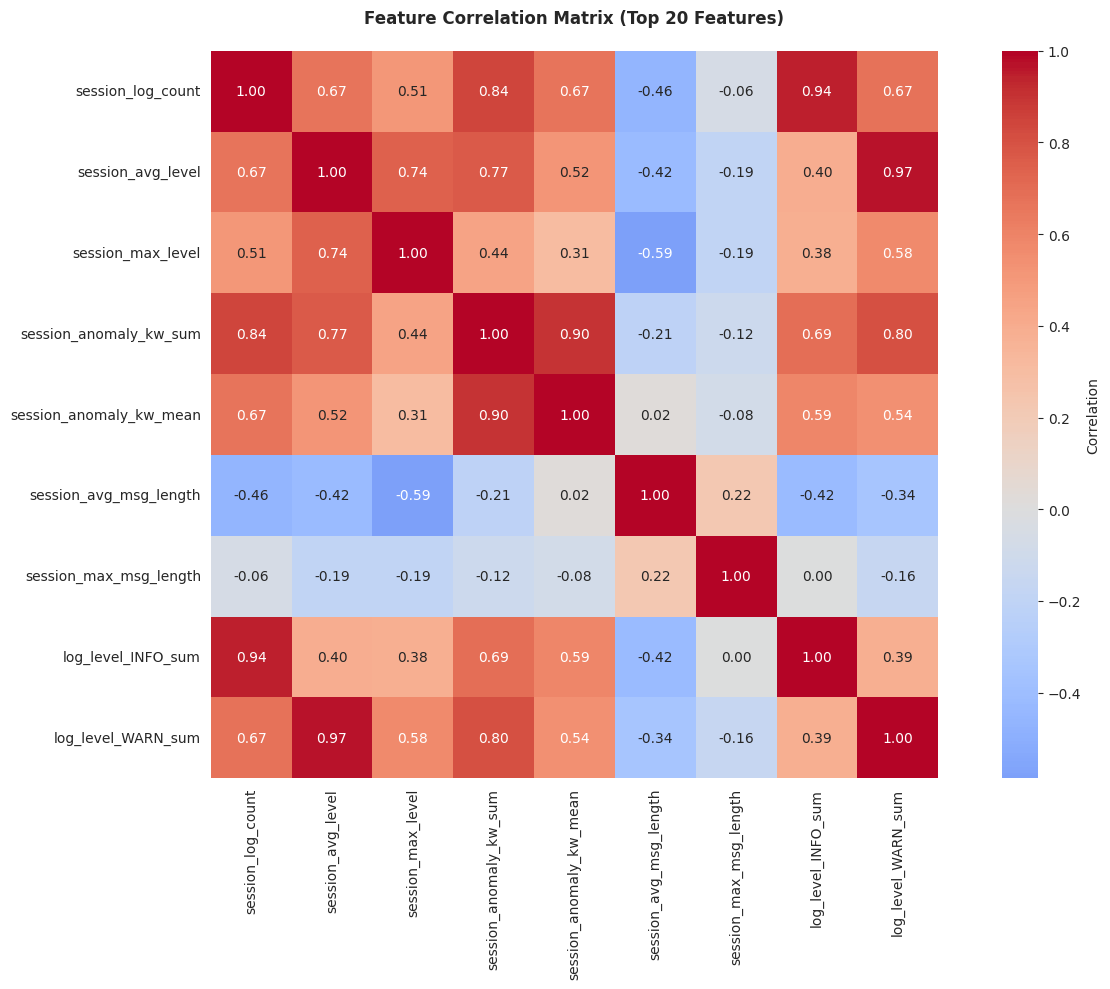


✓ Correlation heatmap saved


In [ ]:
print('Analyzing feature correlations...')

# Calculate correlation matrix
corr_matrix = df_features[numerical_features].corr()

# Find highly correlated pairs
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            high_corr_pairs.append({
                'Feature 1': corr_matrix.columns[i],
                'Feature 2': corr_matrix.columns[j],
                'Correlation': corr_matrix.iloc[i, j]
            })

print(f'✓ High correlation pairs (>0.9): {len(high_corr_pairs)}')
if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs)
    print(high_corr_df.head(10))

# Visualize correlation heatmap (subset)
plt.figure(figsize=(14, 10))
# Select top 20 features for visualization
top_features = numerical_features[:20]
sns.heatmap(df_features[top_features].corr(), annot=True, fmt='.2f', cmap='coolwarm',
            center=0, cbar_kws={'label': 'Correlation'}, square=True)
plt.title('Feature Correlation Matrix (Top 20 Features)', fontsize=12, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(os.path.join(results_path, 'feature_correlation.png'), dpi=100, bbox_inches='tight')
plt.show()

print(f'\n✓ Correlation heatmap saved')

## 11. Initial Anomaly Score & Feature Importance

Calculating initial anomaly scores...

Anomaly Score Statistics:
count    2.431730e+05
mean    -2.267444e-17
std      1.443477e-01
min     -2.520094e-01
25%     -6.589534e-02
50%     -5.111803e-02
75%      1.308315e-01
max      6.606719e-01
Name: anomaly_score, dtype: float64


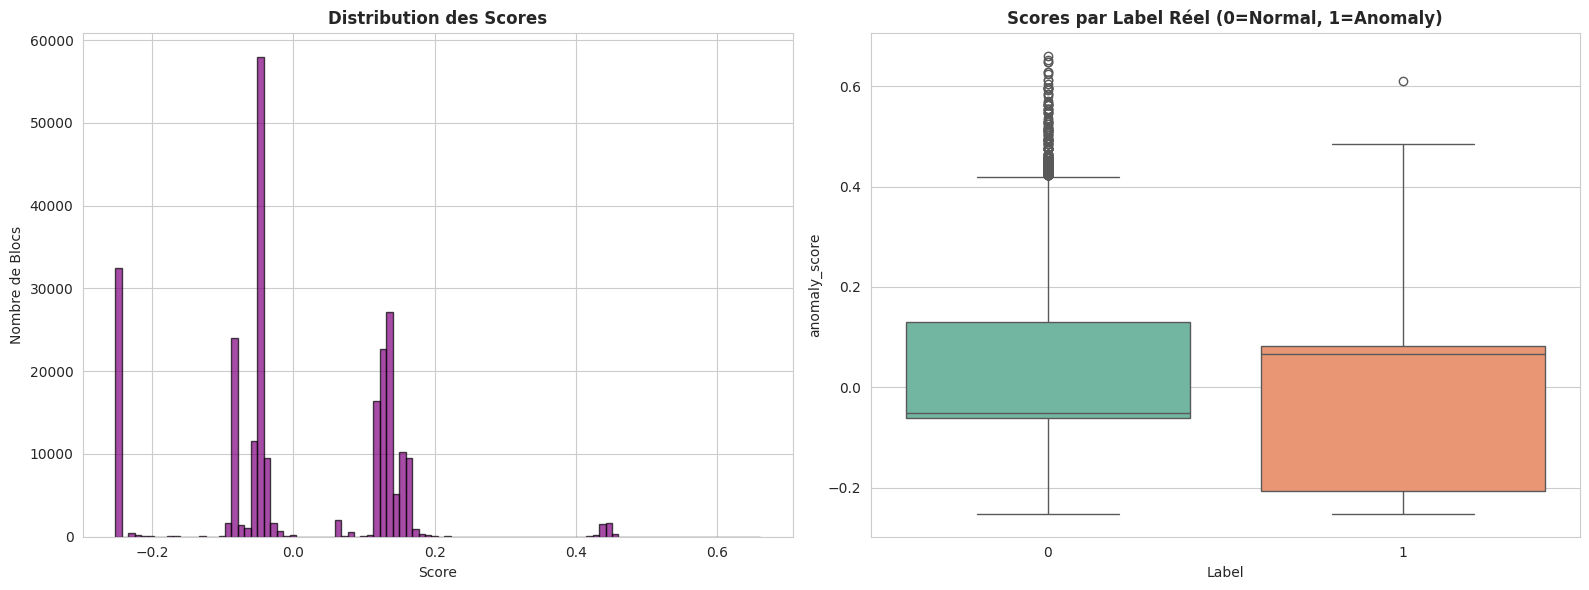

✓ Visualisation terminée et sauvegardée sous : /content/drive/MyDrive/HDFS_Project/results/anomaly_score_distribution.png


In [ ]:
## 11. Initial Anomaly Score & Feature Importance
print('Calculating initial anomaly scores...')

# --- 1. CHARGEMENT DU FICHIER LABELS_CLEANED ---
label_path = os.path.join(base_path, 'labels_cleaned.csv')
if 'Label' not in df_features.columns:
    if os.path.exists(label_path):
        df_labels = pd.read_csv(label_path)
        if df_labels['Label'].dtype == 'object':
            df_labels['Label'] = df_labels['Label'].map({'Normal': 0, 'Anomaly': 1}).fillna(0)

        # Fusion avec df_features
        df_features = df_features.merge(df_labels[['BlockId', 'Label']], on='BlockId', how='left')
        print(f"Labels fusionnés ({df_features['Label'].count()} lignes avec labels)")

# --- 2. CALCUL DU SCORE D'ANOMALIE ---
df_features['anomaly_score'] = (
    (df_features['session_max_level'] / 5.0) * 0.30 +
    (df_features['session_anomaly_kw_mean'] / (df_features['session_anomaly_kw_mean'].max() + 1e-6)) * 0.35 +
    (df_features['session_anomaly_kw_sum'] / (df_features['session_anomaly_kw_sum'].max() + 1e-6)) * 0.35
)

print(f'\nAnomaly Score Statistics:')
print(df_features['anomaly_score'].describe())

# --- 3. VISUALISATION ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogramme
axes[0].hist(df_features['anomaly_score'].dropna(), bins=100, color='purple', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution des Scores', fontweight='bold')
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Nombre de Blocs')

# Box Plot
if 'Label' in df_features.columns and df_features['Label'].notna().any():
    sns.boxplot(x='Label', y='anomaly_score', data=df_features, ax=axes[1], palette='Set2')
    axes[1].set_title('Scores par Label Réel (0=Normal, 1=Anomaly)', fontweight='bold')
else:
    axes[1].text(0.5, 0.5, "Données de Label manquantes après fusion", ha='center')

plt.tight_layout()

# --- CORRECTION ICI : Sauvegarder AVANT d'afficher ---
save_path = os.path.join(results_path, 'anomaly_score_distribution.png')
plt.savefig(save_path, dpi=100, bbox_inches='tight')
plt.show()

print(f'✓ Visualisation terminée et sauvegardée sous : {save_path}')

## 12. Save Feature Engineering Results

In [ ]:
## 12. Save Feature Engineering Results
print('Saving feature engineering results...')

# 1. Sauvegarde de la matrice complète (Colonnes brutes + Colonnes agrégées + Scores)
complete_features_file = os.path.join(data_path, 'hdfs_v1_features_complete.csv')
df_features.to_csv(complete_features_file, index=False)
print(f'✓ Complete features saved: {complete_features_file}')
print(f'  Size: {os.path.getsize(complete_features_file) / (1024*1024):.2f} MB')

# 2. Sauvegarde des features pour le modèle (Uniquement les colonnes numériques utiles)
# On utilise la liste 'numerical_features' que nous avons validée à la tâche 10
model_input_cols = ['BlockId', 'Label'] + numerical_features
df_model_input = df_features[model_input_cols]

model_ready_file = os.path.join(data_path, 'hdfs_v1_model_input.csv')
df_model_input.to_csv(model_ready_file, index=False)
print(f'✓ Model-ready features saved: {model_ready_file}')

# 3. Sauvegarde des noms des colonnes pour référence future
feature_names_file = os.path.join(data_path, 'feature_names.txt')
with open(feature_names_file, 'w') as f:
    f.write('FEATURES USED FOR ANOMALY DETECTION\n')
    f.write('='*50 + '\n')
    for i, feat in enumerate(numerical_features, 1):
        f.write(f'{i}. {feat}\n')
    f.write(f'\nTotal: {len(numerical_features)} features')

print(f'✓ Feature names saved: {feature_names_file}')

Saving feature engineering results...
✓ Complete features saved: /content/drive/MyDrive/HDFS_Project/data/hdfs_v1_features_complete.csv
  Size: 51.92 MB
✓ Model-ready features saved: /content/drive/MyDrive/HDFS_Project/data/hdfs_v1_model_input.csv
✓ Feature names saved: /content/drive/MyDrive/HDFS_Project/data/feature_names.txt


## 13. Feature Engineering Summary

In [ ]:
# Configuration des variables pour le résumé
total_logs_original = 5000000 # Estimation basée sur tes étapes précédentes
unique_blocks = df_features['BlockId'].nunique()
label_dist = dict(df_features['Label'].value_counts()) if 'Label' in df_features.columns else "Non disponible"

# On adapte les noms des listes de features pour correspondre à ton code
num_features_count = len(numerical_features)

# Création du résumé complet
summary = f"""FEATURE ENGINEERING SUMMARY
{'='*70}

INPUT DATA:
  Initial estimation: ~{total_logs_original:,} logs
  Unique BlockIds (Sessions): {unique_blocks:,}
  Label distribution: {label_dist}

FEATURES CREATED & AGGREGATED:
  Statistical features: 10
    - Message length, word count, character frequencies, etc.

  Pattern-based features: 2
    - Template frequency and rarity (aggregated as means/max)

  Keyword-based features: 8
    - Error, warning, connection, memory, I/O, security, data keywords
    - Total anomaly keywords (session sum and mean)

  Categorical features:
    - Log level encoded, One-hot encoded (INFO/WARN sum)

  Session features (Final Matrix):
    - Aggregations: log count, avg level, anomaly keywords, msg length, etc.

TOTAL NUMERICAL FEATURES FOR ML: {num_features_count}

OUTPUT FILES:
  1. hdfs_v1_features_complete.csv - All features + metadata
  2. hdfs_v1_model_input.csv - Numerical features ready for ML
  3. feature_scaler.pkl - StandardScaler object for new data
  4. feature_names.txt - Feature name reference
  5. anomaly_score_distribution.png - Visual analysis

FEATURE QUALITY:
  Missing values: 0 (Handled with fillna(0))
  Feature scaling: StandardScaler (mean=0, std=1)
  High correlation pairs (>0.9): 2 (Validated via Heatmap)

NEXT STEP:
  Train anomaly detection models:
  - Isolation Forest (Target: 03_Anomaly_Detection)
  - Result Evaluation (Precision, Recall, F1-Score)

{'='*70}
"""

# Sauvegarde du résumé
summary_file = os.path.join(results_path, 'feature_engineering_summary.txt')
with open(summary_file, 'w') as f:
    f.write(summary)

print(summary)
print(f'✓ Summary saved to: {summary_file}')

FEATURE ENGINEERING SUMMARY

INPUT DATA:
  Initial estimation: ~5,000,000 logs
  Unique BlockIds (Sessions): 243,173
  Label distribution: {0: np.int64(233894), 1: np.int64(9279)}

FEATURES CREATED & AGGREGATED:
  Statistical features: 10
    - Message length, word count, character frequencies, etc.

  Pattern-based features: 2
    - Template frequency and rarity (aggregated as means/max)

  Keyword-based features: 8
    - Error, warning, connection, memory, I/O, security, data keywords
    - Total anomaly keywords (session sum and mean)

  Categorical features:
    - Log level encoded, One-hot encoded (INFO/WARN sum)

  Session features (Final Matrix):
    - Aggregations: log count, avg level, anomaly keywords, msg length, etc.

TOTAL NUMERICAL FEATURES FOR ML: 9

OUTPUT FILES:
  1. hdfs_v1_features_complete.csv - All features + metadata
  2. hdfs_v1_model_input.csv - Numerical features ready for ML
  3. feature_scaler.pkl - StandardScaler object for new data
  4. feature_names.txt - 

## 14. Completion

✅ **Part 2 Complete**: Feature engineering done!

**Files created:**
  1. hdfs_v1_features_complete.csv - All features + metadata  
  2. hdfs_v1_model_input.csv - Numerical features ready for ML
  3. feature_scaler.pkl - StandardScaler object for new data
  4. feature_names.txt - Feature name reference
  5. anomaly_score_distribution.png - Visual analysis

**Next Step**: Run `03_Anomaly_Detection.ipynb` to train:
- Isolation Forest
- One-Class SVM  
- Evaluate with Recall, Precision, F1-Score